## Capstone Project - The Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

This project aims to select the safest borough in London based on the **total crimes**, explore the **neighborhoods** of that borough to find the **10 most common venues** in each neighborhood and finally cluster the neighborhoods using **k-mean clustering**.

This report will be targeted to people who are looking to **relocate to London**. Inorder to finalise a neighborhood to hunt for an apartment, **safety** is considered as a top concern when moving to a new place. If you don’t feel safe in your own home, you’re not going to be able to enjoy living there. The **crime statistics** will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* The total number of crimes commited in each of the borough during the last year.
* The most common venues in each of the neighborhood in the safest borough selected.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016](#part1):  A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
- [**Part 2**: Scraping additional information of the different Boroughs in London from a Wikipedia page.](#part2): More information regarding the boroughs of London is scraped using the Beautifulsoup library
- [**Part 3**: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.](#part3): Co-ordinate of neighborhood will be obtained using **Google Maps API geocoding**


### Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016<a name="part1"></a>


####  London Crime Data 

About this file

- lsoa_code: code for Lower Super Output Area in Greater London.
- borough: Common name for London borough.
- major_category: High level categorization of crime
- minor_category: Low level categorization of crime within major category.
- value: monthly reported count of categorical crime in given borough
- year: Year of reported counts, 2008-2016
- month: Month of reported counts, 1-12

Data set URL: https://www.kaggle.com/jboysen/london-crime


#### Import necessary libraries

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup # library for web scrapping  

!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Sai Nishitha\anaconda3

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          59 KB

The following NEW packages will be INSTALLED:

  geocoder           conda-forge/noarch::geocoder-1.38.1-py_1
  ratelim            conda-forge/noarch::ratelim-0.1.6-py_2




geocoder-1.38.1      | 53 KB     |            |   0% 
geocoder-1.38.1      | 53 KB     | ###        |  30% 
geocoder-1.38.1      | 53 KB     | ########## | 100% 

ratelim-0.1.6        | 6 KB      |            |   0% 
ratelim-0.1.6      

#### Define Foursquare Credentials and Version
Make sure that you have created a Foursquare developer account and have your credentials handy

In [4]:
CLIENT_ID = '0T4FONHHOQFANBIA0PFL5MURF4NTW3Z3XELQTSTFT3GNOFBM' # your Foursquare ID
CLIENT_SECRET = 'QGDFZMANVVF0XITDQRKFVCGL0V4EZFVJH42V2NT2RLM3S4YT' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 50

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0T4FONHHOQFANBIA0PFL5MURF4NTW3Z3XELQTSTFT3GNOFBM
CLIENT_SECRET:QGDFZMANVVF0XITDQRKFVCGL0V4EZFVJH42V2NT2RLM3S4YT


#### Read in the dataset

In [20]:
# Read in the data 
df = pd.read_csv(r"C:\Users\Sai Nishitha\Downloads\london_crime_by_lsoa.csv")

In [21]:
# View the top rows of the dataset
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0,2016,11
1,E01001646,Greenwich,Violence Against the Person,Other violence,0,2016,11
2,E01000677,Bromley,Violence Against the Person,Other violence,0,2015,5
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0,2016,3
4,E01004563,Wandsworth,Robbery,Personal Property,0,2008,6


#### Accessing the most recent crime rates (2016)

In [22]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [23]:
# Shape of the data frame
df.shape

(392042, 7)

In [24]:
# View the top of the dataset 
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


#### Change the column names 

In [25]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1,2016,8
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1,2016,4
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4,2016,8
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1,2016,8
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2,2016,11


In [26]:
# View the information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392042 entries, 0 to 392041
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   LSOA_Code       392042 non-null  object
 1   Borough         392042 non-null  object
 2   Major_Category  392042 non-null  object
 3   Minor_Category  392042 non-null  object
 4   No_of_Crimes    392042 non-null  int64 
 5   Year            392042 non-null  int64 
 6   Month           392042 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 20.9+ MB


#### Total number of crimes in each Borough

In [27]:
df['Borough'].value_counts()

Lambeth                   17605
Southwark                 16560
Croydon                   16254
Newham                    15622
Ealing                    15284
Tower Hamlets             15219
Brent                     14980
Barnet                    14668
Hackney                   14392
Lewisham                  14235
Haringey                  14202
Enfield                   13658
Wandsworth                13498
Westminster               13383
Islington                 13116
Greenwich                 12750
Camden                    12632
Hillingdon                12417
Hounslow                  12316
Waltham Forest            12121
Bromley                   11980
Redbridge                 11490
Hammersmith and Fulham    10281
Barking and Dagenham       9784
Havering                   9699
Kensington and Chelsea     9653
Harrow                     8257
Bexley                     8245
Merton                     8223
Richmond upon Thames       7199
Sutton                     6823
Kingston

#### The total crimes per major category

In [28]:
df['Major_Category'].value_counts()

Theft and Handling             129159
Violence Against the Person    123050
Criminal Damage                 48584
Burglary                        43020
Drugs                           21782
Robbery                         14889
Other Notifiable Offences       11558
Name: Major_Category, dtype: int64

#### Pivoting the table to view the no. of crimes for each major category in each Borough 

In [31]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham         1287            1949   919   
Barnet                       3402            2183   906   
Bexley                       1123            1673   646   
Brent                        2631            2280  2096   
Bromley                      2214            2202   728   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                       378     534               5607   
Barnet                                     499     464               9731   
Bexley                                     294     209               4392   
Brent                                      536     919               9026   
Bromley                                    417     369               7584   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                        6067  
Barnet                                      7499  
Bexley                                      4503  
Brent                                       9205  
Bromley                                     6650

In [33]:
# Reset the index
London_crime.reset_index(inplace = True)

In [34]:
# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head(33)

index                 Borough No_of_Crimes                  \
Major_Category                                   Burglary Criminal Damage   
0                  0    Barking and Dagenham         1287            1949   
1                  1                  Barnet         3402            2183   
2                  2                  Bexley         1123            1673   
3                  3                   Brent         2631            2280   
4                  4                 Bromley         2214            2202   
5                  5                  Camden         2652            1935   
6                  6          City of London            2               2   
7                  7                 Croydon         2738            3219   
8                  8                  Ealing         2492            2562   
9                  9                 Enfield         2541            2136   
10                10               Greenwich         1780            2476   
11                11                 Hackney         2719            1981   
12                12  Hammersmith and Fulham         1531            1408   
13                13                Haringey         2474            2233   
14                14                  Harrow         1994            1212   
15                15                Havering         1826            1804   
16                16              Hillingdon         2229            2470   
17                17                Hounslow         1808            2213   
18                18               Islington         2051            1903   
19                19  Kensington and Chelsea         1449            1051   
20                20    Kingston upon Thames          879            1054   
21                21                 Lambeth         3087            2764   
22                22                Lewisham         2071            2351   
23                23                  Merton         1419            1418   
24                24                  Newham         2115            2496   
25                25               Redbridge         1997            1650   
26                26    Richmond upon Thames         1359            1148   
27                27               Southwark         2946            2621   
28                28                  Sutton         1233            1316   
29                29           Tower Hamlets         2794            2357   
30                30          Waltham Forest         1873            1989   
31                31              Wandsworth         2351            1836   
32                32             Westminster         3218            2179   

                                                                           \
Major_Category Drugs Other Notifiable Offences Robbery Theft and Handling   
0                919                       378     534               5607   
1                906                       499     464               9731   
2                646                       294     209               4392   
3               2096                       536     919               9026   
4                728                       417     369               7584   
5               1493                       490     899              14088   
6                 10                         6       4                129   
7               1367                       718    1139               9229   
8               1355                       613     669              10040   
9               1063                       492     807               8037   
10               867                       521     486               8010   
11              1353                       499    1030              11851   
12              1321                       474     397               8925   
13              1540                       551    1248              10554   
14               473                       267     377               4537   
15        

#### Removing the multi index so that it will be easier to merge

In [35]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()

,index,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,1,Barnet,3402,2183,906,499,464,9731,7499,24685
2,2,Bexley,1123,1673,646,294,209,4392,4503,12842
3,3,Brent,2631,2280,2096,536,919,9026,9205,26696
4,4,Bromley,2214,2202,728,417,369,7584,6650,20168


#### Renaming the columns

In [38]:
London_crime.columns = ['index','Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,index,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741
1,1,Barnet,3402,2183,906,499,464,9731,7499,24685
2,2,Bexley,1123,1673,646,294,209,4392,4503,12842
3,3,Brent,2631,2280,2096,536,919,9026,9205,26696
4,4,Bromley,2214,2202,728,417,369,7584,6650,20168


In [39]:
# Shape of the data set 
London_crime.shape

(33, 10)

In [40]:
# View the Columns in the data frame
# London_crime.columns.tolist()

### Part 2: Scraping additional information of the different Boroughs in London from a Wikipedia page <a name="part2"></a>
 
**Using Beautiful soup to scrap the latitude and longitiude of the boroughs in London**

URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

In [41]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page= requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page,'xml')
print(soup.prettify())


<?xml version="1.0" encoding="utf-8"?>
<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="UTF-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"X@FC6gpAAEAAAAYHvtkAAAAS","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":994741741,"wgRevisionId":994741741,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates"

In [42]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

#### Converting the table into a data frame 

In [43]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


#### The second table on the site contains the addition Borough i.e. City of London

In [44]:
# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


#### Append the data frame together

In [45]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


#### Check if the last row was appended correctly

In [46]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1


#### View the information of the data set

In [47]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


#### Removing Unnecessary string in the Data set

In [48]:
London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


#### Check the type of the newly created table

In [49]:
type(London_table)

pandas.core.frame.DataFrame

In [50]:
# Shape of the data frame
London_table.shape

(33, 10)

#### Check if the Borough in both the data frames match.

In [51]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

These 3 Boroughs don't match because of the unnecessary symobols present "[]" 

#### Find the index of the Boroughs that didn't match

In [52]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]


#### Changing the Borough names to match the other data frame

In [53]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

#### Check if the Borough names in both data sets match

In [54]:
set(df.Borough) - set(London_table.Borough)

set()

The Borough names in both data frames match 

#### We can combine both the data frames together

In [55]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head(10)

,index,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,0,Barking and Dagenham,1287,1949,919,378,534,5607,6067,16741,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,1,Barnet,3402,2183,906,499,464,9731,7499,24685,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,2,Bexley,1123,1673,646,294,209,4392,4503,12842,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,3,Brent,2631,2280,2096,536,919,9026,9205,26696,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,4,Bromley,2214,2202,728,417,369,7584,6650,20168,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,5,Camden,2652,1935,1493,490,899,14088,7626,29188,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,229719,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,6,City of London,2,2,10,6,4,129,25,184,([],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1
7,7,Croydon,2738,3219,1367,718,1139,9229,10302,28719,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
8,8,Ealing,2492,2562,1355,613,669,10040,9396,27135,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,342494,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
9,9,Enfield,2541,2136,1063,492,807,8037,7409,22494,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,320524,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30


In [56]:
Ld_crime.shape

(33, 19)

In [57]:
set(df.Borough) - set(Ld_crime.Borough)

set()

#### Rearranging the Columns 

In [58]:
# List of Column names of the data frame 
list(Ld_crime)

['index',
 'Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

In [59]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,".mw-parser-output .geo-default,.mw-parser-outp...",1287,1949,919,378,534,5607,6067,16741
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,3402,2183,906,499,464,9731,7499,24685
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,1123,1673,646,294,209,4392,4503,12842
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,2631,2280,2096,536,919,9026,9205,26696
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,2214,2202,728,417,369,7584,6650,20168


## Methodology <a name="methodology"></a>

The methodology in this project consists of two parts:
- [Exploratory Data Analysis](#EDA): Visualise the crime rates in the London boroughs to idenity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.


- [Modelling](#modelling): To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.
 

### Exploratory Data Analysis <a name="EDA"></a>

#### Descriptive statistics of the data

In [60]:
London_crime.describe()

,index,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.00000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.00000
mean,16.00000,2069.242424,1941.545455,1179.212121,479.060606,682.666667,8913.121212,7041.848485,22322.69697
std,9.66954,737.448644,625.207070,586.406416,223.298698,441.425366,4620.565054,2513.601551,8830.12487
min,0.00000,2.000000,2.000000,10.000000,6.000000,4.000000,129.000000,25.000000,184.00000
25%,8.00000,1531.000000,1650.000000,743.000000,378.000000,377.000000,5919.000000,5936.000000,16918.00000
50%,16.00000,2071.000000,1989.000000,1063.000000,490.000000,599.000000,8925.000000,7409.000000,22740.00000
75%,24.00000,2631.000000,2351.000000,1617.000000,551.000000,936.000000,10789.000000,8832.000000,27187.00000
max,32.00000,3402.000000,3219.000000,2738.000000,1305.000000,1822.000000,27520.000000,10834.000000,48362.00000


In [61]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.3


#### Check if the column names are strings 

In [62]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

#### Sort the total crimes in descenting order to see 5  boroughs with the highest number of crimes 

In [63]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,3218,2179,2049,708,1822,27520,10834,48362
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,3087,2764,2738,635,1196,13155,10496,34092
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,2946,2621,1838,494,1317,12946,9474,31663
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,2115,2496,1684,713,1472,11964,9646,30114
29,Tower Hamlets,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,2794,2357,1629,678,1234,10953,9608,29282


#### Visualize the five boroughs with the highest number of crimes 

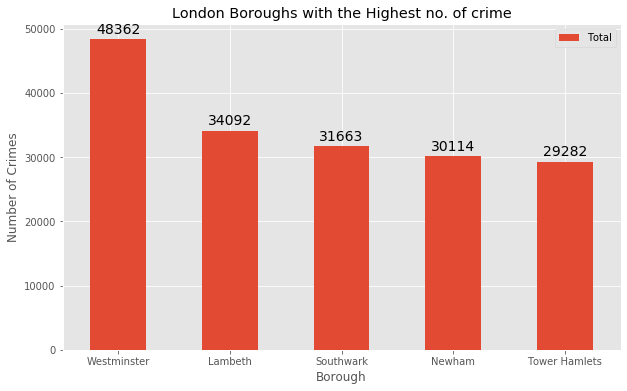

In [64]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

### We'll stay clear from these places :)

#### Sort the total crimes in ascending order to see 5  boroughs with the highest number of crimes 

In [65]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,2,2,10,6,4,129,25,184
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,879,1054,743,189,121,3803,3194,10003
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,1233,1316,461,253,165,3516,3714,10686
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,1359,1148,320,217,106,4769,3155,11100
23,Merton,Merton London Borough Council,Labour,"Civic Centre, London Road",14.52,203223,51°24′05″N 0°11′45″W﻿ / ﻿51.4014°N 0.1958°W,1419,1418,466,249,283,4894,4026,12778


#### Visualize the five boroughs with the least number of crimes 

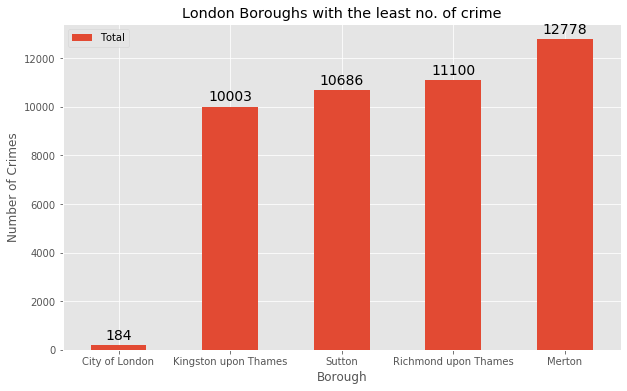

In [66]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

The borough City of London has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough: 

In [67]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,184,1.12,7000


#### As per the wikipedia page, The City of London is the 33rd principal division of Greater London but it is not a London borough. 
URL: https://en.wikipedia.org/wiki/List_of_London_boroughs

#### Hence we will focus on the next borough with the least crime i.e. Kingston upon Thames

### Visualizing different types of crimes in the borough 'Kingston upon Thames'

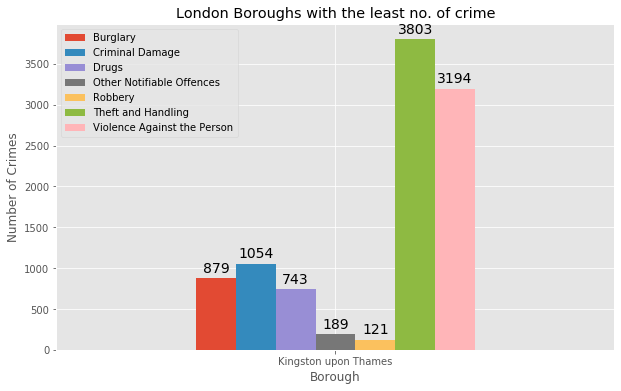

In [68]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()


We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London. 

### Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates. <a name="part3"></a>



The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page: https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [69]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


#### Find the Co-ordiantes of each Neighborhood in the Kingston upon Thames Neighborhood

In [70]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


In [71]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


#### Get the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames)

In [72]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


#### Visualize the Neighborhood of Kingston upon Thames Borough

In [73]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

### Modelling <a name="modelling"></a>

- Finding all the venues within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

#### Create a function to extract the venues from each Neighborhood

In [74]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [75]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )


Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [76]:
print(kut_venues.shape)
kut_venues.head()

(194, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Berrylands,51.393781,-0.284802,Cafe Rosa,51.390175,-0.282490,Café
4,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park


In [77]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,4,4,4,4,4,4
Canbury,14,14,14,14,14,14
Coombe,1,1,1,1,1,1
Hook,5,5,5,5,5,5
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,50,50,50,50,50,50
Malden Rushett,4,4,4,4,4,4
Motspur Park,4,4,4,4,4,4
New Malden,7,7,7,7,7,7


In [78]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 78 uniques categories.


#### One hot encoding

URL: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [79]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,...,Spa,Stationery Store,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [80]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bookstore,Bowling Alley,Breakfast Spot,...,Spa,Stationery Store,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Turkish Restaurant,Wine Shop
0,Berrylands,0.00,0.000000,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
1,Canbury,0.00,0.000000,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.071429,0.00,0.071429,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
2,Coombe,0.00,0.000000,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,1.00000,0.000000,0.00,0.000000,0.00,0.000000
3,Hook,0.00,0.000000,0.20000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.200000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
4,Kingston Vale,0.00,0.000000,0.00000,0.250000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
5,Kingston upon Thames,0.02,0.000000,0.02000,0.000000,0.02,0.00000,0.02,0.000000,0.000000,...,0.000000,0.02,0.020000,0.060000,0.00000,0.020000,0.02,0.000000,0.02,0.000000
6,Malden Rushett,0.00,0.000000,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
7,Motspur Park,0.00,0.000000,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.000000
8,New Malden,0.00,0.000000,0.00000,0.142857,0.00,0.00000,0.00,0.000000,0.000000,...,0.000000,0.00,0.142857,0.142857,0.00000,0.000000,0.00,0.000000,0.00,0.000000
9,Norbiton,0.00,0.037037,0.00000,0.000000,0.00,0.00000,0.00,0.000000,0.037037,...,0.037037,0.00,0.037037,0.000000,0.00000,0.037037,0.00,0.000000,0.00,0.037037


In [81]:
kut_grouped.shape

(14, 79)

In [82]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.25
1              Bus Stop  0.25
2                  Park  0.25
3                  Café  0.25
4                 Plaza  0.00


----Canbury----
                  venue  freq
0                   Pub  0.29
1           Supermarket  0.07
2  Gym / Fitness Center  0.07
3     Fish & Chips Shop  0.07
4                  Park  0.07


----Coombe----
              venue  freq
0          Tea Room   1.0
1  Asian Restaurant   0.0
2            Market   0.0
3          Platform   0.0
4       Pizza Place   0.0


----Hook----
               venue  freq
0                Pub   0.2
1             Bakery   0.2
2  Indian Restaurant   0.2
3  Fish & Chips Shop   0.2
4        Supermarket   0.2


----Kingston Vale----
              venue  freq
0      Soccer Field  0.25
1     Grocery Store  0.25
2               Bar  0.25
3    Sandwich Place  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames----
                venue  freq
0         Coff

#### Create a data frame of the venues 
Function to sort the venues in descending order.

In [83]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighborhood

In [84]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Café,Bus Stop,Wine Shop,Fish & Chips Shop,Department Store,Discount Store,Electronics Store,Farmers Market
1,Canbury,Pub,Shop & Service,Fish & Chips Shop,Plaza,Café,Indian Restaurant,Hotel,Spa,Park,Supermarket
2,Coombe,Tea Room,Wine Shop,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant
3,Hook,Fish & Chips Shop,Bakery,Pub,Supermarket,Indian Restaurant,Wine Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store
4,Kingston Vale,Grocery Store,Bar,Sandwich Place,Soccer Field,German Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Electronics Store


### Clustering similar neighborhoods together using k - means clustering

In [85]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 0, 1, 4, 1, 4, 4, 1, 1])

In [86]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Gym / Fitness Center,Park,Café,Bus Stop,Wine Shop,Fish & Chips Shop,Department Store,Discount Store,Electronics Store,Farmers Market
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1.0,Pub,Shop & Service,Fish & Chips Shop,Plaza,Café,Indian Restaurant,Hotel,Spa,Park,Supermarket
2,Chessington,Kingston upon Thames,51.358336,-0.298622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Coombe,Kingston upon Thames,51.419450,-0.265398,0.0,Tea Room,Wine Shop,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant
4,Hook,Kingston upon Thames,51.367898,-0.307145,1.0,Fish & Chips Shop,Bakery,Pub,Supermarket,Indian Restaurant,Wine Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store


In [87]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            15 non-null     object 
 1   Borough                 15 non-null     object 
 2   Latitude                15 non-null     float64
 3   Longitude               15 non-null     float64
 4   Cluster Labels          14 non-null     float64
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

In [88]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [89]:
kut_merged.shape

(14, 15)

In [90]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [91]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            14 non-null     object 
 1   Borough                 14 non-null     object 
 2   Latitude                14 non-null     float64
 3   Longitude               14 non-null     float64
 4   Cluster Labels          14 non-null     int32  
 5   1st Most Common Venue   14 non-null     object 
 6   2nd Most Common Venue   14 non-null     object 
 7   3rd Most Common Venue   14 non-null     object 
 8   4th Most Common Venue   14 non-null     object 
 9   5th Most Common Venue   14 non-null     object 
 10  6th Most Common Venue   14 non-null     object 
 11  7th Most Common Venue   14 non-null     object 
 12  8th Most Common Venue   14 non-null     object 
 13  9th Most Common Venue   14 non-null     object 
 14  10th Most Common Venue  14 non-null     obje

### Visualize the clusters

In [92]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster. Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five. The green cluster consists of two neighborhoods which is the 4th cluster. 

## Analysis <a name="analysis"></a>

Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

#### Examine the first cluster

In [93]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Coombe,Kingston upon Thames,51.41945,-0.265398,0,Tea Room,Wine Shop,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market,Fast Food Restaurant


The cluster one is the biggest cluster with 9 of the 15 neighborhoods in the borough Kingston upon Thames. Upon closely examining these neighborhoods we can see that the most common venues in these neighborhoods are Restaurants, Pubs, Cafe, Supermarkets,  and stores.

#### Examine the second cluster

In [94]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,1,Pub,Shop & Service,Fish & Chips Shop,Plaza,Café,Indian Restaurant,Hotel,Spa,Park,Supermarket
4,Hook,Kingston upon Thames,51.367898,-0.307145,1,Fish & Chips Shop,Bakery,Pub,Supermarket,Indian Restaurant,Wine Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,1,Coffee Shop,Department Store,Sushi Restaurant,Café,Burger Joint,Clothing Store,Pub,Italian Restaurant,Pedestrian Plaza,Mexican Restaurant
9,New Malden,Kingston upon Thames,51.405335,-0.263407,1,Grocery Store,Sushi Restaurant,Korean Restaurant,Supermarket,Indian Restaurant,Gastropub,Bar,Garden Center,Fast Food Restaurant,Deli / Bodega
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,1,Food,Indian Restaurant,Italian Restaurant,Platform,Pub,Wine Shop,Rental Car Location,Farmers Market,Hardware Store,Hotel
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,1,Indian Restaurant,Coffee Shop,Pub,Italian Restaurant,Fish & Chips Shop,Park,Chinese Restaurant,Restaurant,Fast Food Restaurant,Café
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,1,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy,Breakfast Spot,French Restaurant,Gourmet Shop,Gym / Fitness Center,Farmers Market


The second cluster has one neighborhood which consists of Venues such as Restaurants, Golf courses, and wine shops.  

#### Examine the third cluster

In [95]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,2,Construction & Landscaping,Food,Train Station,Fish & Chips Shop,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market


The third cluster has one neighborhood which consists of Venues such as Train stations, Restaurants, and Furniture shops.  

#### Examine the forth cluster

In [96]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Gym / Fitness Center,Park,Café,Bus Stop,Wine Shop,Fish & Chips Shop,Department Store,Discount Store,Electronics Store,Farmers Market


The fourth cluster has two neighborhoods in it, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields etc. 


#### Examine the fifth cluster

In [97]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138,4,Grocery Store,Bar,Sandwich Place,Soccer Field,German Restaurant,Fast Food Restaurant,Deli / Bodega,Department Store,Discount Store,Electronics Store
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,4,Grocery Store,Pub,Garden Center,Restaurant,Fast Food Restaurant,Cosmetics Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,4,Soccer Field,Gym,Park,Restaurant,Fish & Chips Shop,Deli / Bodega,Department Store,Discount Store,Electronics Store,Farmers Market
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,4,Grocery Store,Pharmacy,Bowling Alley,Coffee Shop,Pizza Place,Discount Store,Café,Bus Stop,Restaurant,Sandwich Place


The fifth cluster has one neighborhood which consists of Venues such as Grocery shops, Bars, Restaurants, Furniture shops, and Department stores.

## Results and Discussion <a name="results"></a>

The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it. For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues. If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable. For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family. 

## Conclusion <a name="conclusion"></a>

This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood. It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood. We have just taken safety as a primary concern to shortlist the borough of London. The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.  